In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import concatenate, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Activation, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# seed
import os
seed = 123
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
train = np.load('data/train.npy', allow_pickle = 'True')
test = np.load('data/test.npy', allow_pickle = 'True')

In [3]:
train_image = train[:,2:].reshape(-1,28,28).astype(np.int)
train_digit = train[:,0]
train_letter = train[:,1]
train_del_noise = np.where(train_image>=150, train_image, 0)

test_image = test[:,1:].reshape(-1,28,28).astype(np.int)

In [4]:
def class_pca_mean(data, num, n):
    lst = []
    for idx in range(len(data)):
        if train_digit[idx] == num:
            lst.append(data[idx])
    lst = np.array(lst)
    
    pca = PCA(n_components=n)
    x = lst.reshape(lst.shape[0],-1).copy()
    w = pca.fit_transform(x)
    return pca.mean_

In [5]:
label_0 = class_pca_mean(train_image, 0, 5)
label_1 = class_pca_mean(train_image, 1, 5)
label_2 = class_pca_mean(train_image, 2, 5)
label_3 = class_pca_mean(train_image, 3, 5)
label_4 = class_pca_mean(train_image, 4, 5)
label_5 = class_pca_mean(train_image, 5, 5)
label_6 = class_pca_mean(train_image, 6, 5)
label_7 = class_pca_mean(train_image, 7, 5)
label_8 = class_pca_mean(train_image, 8, 5)
label_9 = class_pca_mean(train_image, 9, 5)

In [6]:
mid_label = []
for idx in range(len(train_digit)):
    if train_digit[idx] == 0:
        mid_label.append(label_0)
    elif train_digit[idx] == 1:
        mid_label.append(label_1)
    elif train_digit[idx] == 2:
        mid_label.append(label_2)
    elif train_digit[idx] == 3:
        mid_label.append(label_3)
    elif train_digit[idx] == 4:
        mid_label.append(label_4)
    elif train_digit[idx] == 5:
        mid_label.append(label_5)
    elif train_digit[idx] == 6:
        mid_label.append(label_6)
    elif train_digit[idx] == 7:
        mid_label.append(label_7)
    elif train_digit[idx] == 8:
        mid_label.append(label_8)
    else:
        mid_label.append(label_9)
mid_label = np.array(mid_label)
m = mid_label.copy()
#m = mid_label.reshape(-1,mid_label.shape[0])

In [7]:
m.shape

(2048, 784)

In [8]:
m[0].shape

(784,)

In [9]:
m[0]

array([  1.89777778,   1.85777778,   2.01333333,   2.04      ,
         2.04444444,   2.        ,   1.94222222,   1.93333333,
         1.99111111,   1.87555556,   2.07111111,   2.08      ,
         2.06222222,   1.88      ,   1.87111111,   2.08      ,
         1.91555556,   1.96      ,   1.91111111,   1.92444444,
         1.80444444,   2.06222222,   1.96444444,   1.89333333,
         1.94666667,   2.14222222,   2.02222222,   1.98666667,
         1.80444444,   1.93333333,   1.94222222,   1.99111111,
         2.00444444,   1.84      ,   1.97777778,   2.17333333,
         1.96888889,   2.10666667,   2.15111111,   2.24      ,
         2.29777778,   2.2       ,   2.20888889,   2.13777778,
         2.21777778,   2.52888889,   2.64444444,   2.17333333,
         2.22666667,   2.37777778,   2.19111111,   2.12      ,
         2.08      ,   1.94666667,   1.91555556,   1.91111111,
         1.96      ,   1.90222222,   2.04      ,   1.87555556,
         2.32888889,   3.01333333,   3.90666667,   3.24

(-0.5, 27.5, 27.5, -0.5)

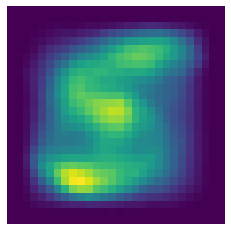

In [10]:
plt.imshow(m[0].reshape(28,28))
plt.axis('off')

In [11]:
#scaler = MinMaxScaler()
#scaler.fit(m)
#m_scaled = scaler.transform(m)

In [12]:
x = train[:,2:]
x = np.reshape(x, (-1, 28, 28, 1))
x = x.astype(np.float32)
#x_raw = train_image.copy()
#x = np.where(x_raw>=150, x_raw, 0)
#x = np.reshape(x, (x.shape[0], x.shape[1], x.shape[2], 1))
#x = x/255

y = train[:,0]
y = np.reshape(y, (-1, 1))
en = OneHotEncoder()
y = en.fit_transform(y).toarray()

print(x.shape)
print(y.shape)

(2048, 28, 28, 1)
(2048, 10)


In [13]:
valid_size = 48
valid_x = x[-valid_size:]
x = x[:-valid_size]

valid_y = y[-valid_size:]
y = y[:-valid_size]

valid_m = m[-valid_size:]
m = m[:-valid_size]

print(x.shape)
print(valid_x.shape)
print(y.shape)
print(valid_y.shape)
print(m.shape)
print(valid_m.shape)

(2000, 28, 28, 1)
(48, 28, 28, 1)
(2000, 10)
(48, 10)
(2000, 784)
(48, 784)


In [14]:
image_generator = ImageDataGenerator(width_shift_range=0.1,
                                     height_shift_range=0.1, 
                                     zoom_range=[0.8,1.2],
                                     shear_range=10)

In [15]:
x_total = x.copy()
def augment(x):
    aug_list = []
    for i in range(x.shape[0]):
        num_aug = 0
        tmp = x[i]
        tmp = tmp.reshape((1,) + tmp.shape)
        for x_aug in image_generator.flow(tmp, batch_size = 1) :
            if num_aug >= 1:
                break
            aug_list.append(x_aug[0])
            num_aug += 1
    aug_list = np.array(aug_list)
    return aug_list

n = 2
for i in range(n):
    arr = augment(x)
    x_total = np.concatenate((x_total, arr), axis=0)
    if i > n:
        break

print(x_total.shape)

(6000, 28, 28, 1)


In [16]:
y_total = y.copy()
for i in range(n):
    arr = y.copy()
    y_total = np.concatenate((y_total, arr), axis=0)
    
m_total = m.copy()
for i in range(n):
    arr = m.copy()
    m_total = np.concatenate((m_total, arr), axis=0)

print(y_total.shape)
print(m_total.shape)

(6000, 10)
(6000, 784)


In [17]:
x_train, x_val, y_train, y_val = train_test_split(x_total, y_total, test_size=0.2, 
                                                  shuffle=True)#, stratify=y_total)

m_train = m_total[:x_train.shape[0],:]
m_val = m_total[x_train.shape[0]:,:]

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)
print(m_train.shape)
print(m_val.shape)

(4800, 28, 28, 1)
(1200, 28, 28, 1)
(4800, 10)
(1200, 10)
(4800, 784)
(1200, 784)


In [18]:
def CNN(model_input, classes):
    x = Conv2D(64, (3,3), activation='elu', padding='same')(model_input)
    x = Conv2D(64, (3,3), activation='elu', padding='same')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='elu', padding='same')(x)
    x = Conv2D(64, (3,3), activation='elu', padding='same')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D((2,2))(x)
    #x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    #x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    #x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(2000, activation='elu')(x)
    x = Dropout(0.3)(x)
    x = Dense(1000, activation='elu')(x)
    x = Dropout(0.3)(x)
    #x = GlobalAveragePooling2D()(x)
    outputs = Dense(classes, activation='elu')(x)
    
    model = Model(inputs = model_input, outputs = outputs)
    
    return model

In [19]:
def DNN(model_input, classes):
    x = Dense(1000, activation='elu', kernel_initializer='he_normal')(model_input)
    #x = Dropout(0.3)(x)
    x = Dense(2000, activation='elu', kernel_initializer='he_normal')(x)
    #x = Dropout(0.3)(x)
    x = Dense(3000, activation='elu', kernel_initializer='he_normal')(x)
    #x = Dropout(0.3)(x)
    x = Dense(2000, activation='elu', kernel_initializer='he_normal')(x)
    #x = Dropout(0.3)(x)
    x = Dense(1000, activation='elu', kernel_initializer='he_normal')(x)
    #x = Dropout(0.3)(x)
    outputs = Dense(classes, activation='elu', kernel_initializer='he_normal')(x)
    
    model = Model(inputs = model_input, outputs = outputs)
    
    return model

In [20]:
layers_in_block = {'DenseNet-121':[6, 12, 24, 16],
                   'DenseNet-169':[6, 12, 32, 32],
                   'DenseNet-201':[6, 12, 48, 32],
                   'DenseNet-265':[6, 12, 64, 48],
                   'myDenseNet':[8, 12, 16, 32]}

base_growth_rate = 32

model_input = Input(shape=(28,28,1))
classes = 784

#model = DenseNet(model_input, classes, 'DenseNet-121')
model = CNN(model_input, classes)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928 

In [21]:
model.compile(optimizer = 'adam', metrics = ['mae'], loss = 'mse')
history = model.fit(x_train, m_train, validation_data=(x_val, m_val), 
                    batch_size=64, epochs=10, verbose=1)

Train on 4800 samples, validate on 1200 samples
Epoch 1/10
4800/4800 [==============================] - 24s 5ms/sample - loss: 511.4162 - mae: 13.6695 - val_loss: 248.8698 - val_mae: 10.2620
Epoch 2/10
4800/4800 [==============================] - 23s 5ms/sample - loss: 163.8393 - mae: 8.9020 - val_loss: 404.7776 - val_mae: 13.2260
Epoch 3/10
4800/4800 [==============================] - 24s 5ms/sample - loss: 145.1438 - mae: 8.4465 - val_loss: 300.9579 - val_mae: 11.2945
Epoch 4/10
4800/4800 [==============================] - 24s 5ms/sample - loss: 139.8224 - mae: 8.2149 - val_loss: 242.8270 - val_mae: 10.0405
Epoch 5/10
4800/4800 [==============================] - 24s 5ms/sample - loss: 136.0411 - mae: 8.0279 - val_loss: 213.6019 - val_mae: 9.4079
Epoch 6/10
4800/4800 [==============================] - 27s 6ms/sample - loss: 132.9735 - mae: 7.8810 - val_loss: 178.3659 - val_mae: 8.6282
Epoch 7/10
4800/4800 [==============================] - 29s 6ms/sample - loss: 131.5114 - mae: 7.7666

In [22]:
valid_x = tf.cast(valid_x, tf.float32)
pred = model.predict(valid_x)
pred.shape

(48, 784)

In [23]:
pred

array([[-1.        , -0.99999994,  2.0643244 , ..., -0.99999994,
        -1.        , -0.9999998 ],
       [-0.99999994, -0.99999976,  2.4688754 , ..., -0.99999684,
        -1.        , -0.99998945],
       [-1.        , -0.99999994,  2.9655967 , ..., -0.9999993 ,
        -1.        , -0.99999917],
       ...,
       [-0.99999994, -0.99999976,  2.2890143 , ..., -0.9999921 ,
        -1.        , -0.9999876 ],
       [-1.        , -0.9999998 ,  2.9927979 , ..., -0.9999977 ,
        -1.        , -0.999998  ],
       [-1.        , -0.99999964,  2.551949  , ..., -0.99999934,
        -1.        , -0.99999905]], dtype=float32)

(-0.5, 27.5, 27.5, -0.5)

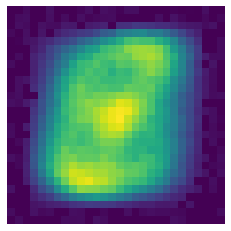

In [24]:
img = pred[0].reshape(28,28)
plt.imshow(img)
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

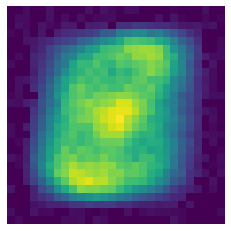

In [25]:
img = pred[30].reshape(28,28)
plt.imshow(img)
plt.axis('off')